## Implementing CPPI and Drawdown Constraints

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import analysis_kit as ak

In [2]:
# Load the industry returns and total market index that we previously created

ind_return=ak.get_ind_returns()

In [4]:
# Selecting industries as our test data for risky asset

risky_r=ind_return["2000":][["Steel","Fin","Beer"]] 

In [8]:
risky_r.shape

(228, 3)

In [5]:
# safe asstets

safe_r=pd.DataFrame().reindex_like(risky_r) # reindex_like simply mimics and recreates the dimensions of the provided df 

In [15]:
# We are gonna assume that for all the 228 periods, the rf asset will return annually 3%. Hence, we have to convert this to a 
# monthly figure

safe_r[:]=0.03/12
start=1000 # Starting dollar amount
floor= 0.8 # floor of 80% of the starting value


### STEPS 

1. Cushion= Asset value - Floor value

2. Compute an allocation to safe and risky asset ----> M * Risk Budget

3. Recompute the asset value based on the returns 

#### CPPI Algo

In [36]:
dates=risky_r.index # dates are needed coz we are gonna ask the algo to reiterate over a bunch of dates

n_steps=len(dates) # Simply the number of monthly periodic dates. Since our data is monthly data, its just total no. of months

account_value=start # we have to know what is our account value at any point in time t 

floor_value= start * floor # multiplication because the floor was earlier set as a percentage figure

m= 3

# This part is not actually "needed" for the CPPI algo but it is really good for us to observe as we run the algo
# Since cppi is essentially a backtest, at each stage of the backtest

account_history= pd.DataFrame().reindex_like(risky_r)
cushion_history= pd.DataFrame().reindex_like(risky_r)
risky_w_history= pd.DataFrame().reindex_like(risky_r)

# Core of the CPPI Algo: the for loop

for step in range(n_steps): # the "step" here refers to an arbitrary variable filled for the loop to run. In our case, it refers
                            # to the no. of rows in the n_steps. 
                            # range(n_steps) simply means the body of the loop is gonna be executed first with step=1, then 
                            # step=2 and all the way to n_steps (not including the n_step)
    
    cushion=(account_value-floor_value)/account_value

    risky_w= m * cushion
    
    risky_w= np.minimum(risky_w, 1) # This means the min weight of risky asset is the lower of whatever we got as risky_w and 1
    
    risky_w= np.maximum(risky_w, 0) # Means the max weight of risky asset is the higher of whatever we got as risky_w and 0
    
    safe_w= 1-risky_w # This is pretty intuitive
    
    risky_alloc= account_value * risky_w
    
    safe_alloc= account_value * safe_w
    
    ## update the account value for a each time step. Account value, as you can see, is just combination of risky and rf assets
    
    account_value= (risky_alloc * (1+risky_r.iloc[step])) + (safe_alloc * (1+safe_r.iloc[step]))
    
    ## save the values so that I can see at the history and plot it
    
    account_history.iloc[step]=account_value
    cushion_history.iloc[step]=cushion
    risky_w_history.iloc[step]=risky_w
    

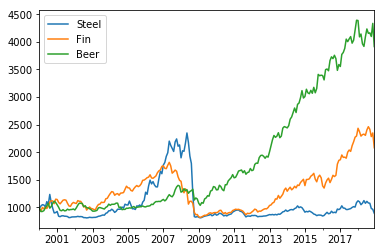

In [37]:
account_history.plot()

#### Below is what I would get if I had done none of the CPPI and just invested all the 1000 dollars in the risky asset

In [20]:
risky_wealth= start * (1+risky_r).cumprod()

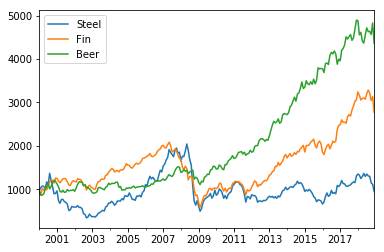

In [21]:
risky_wealth.plot()

#### Now, lets pick an industry as risky asset and compare its generated wealth to the returns of cppi

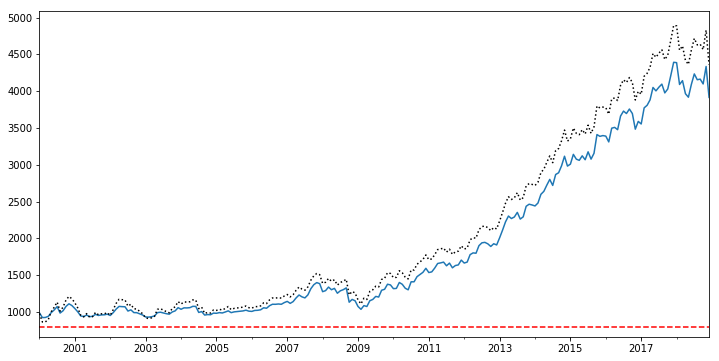

In [38]:
ax=account_history["Beer"].plot(figsize=(12,6))
risky_wealth["Beer"].plot(ax=ax, style="k:")
ax.axhline(y=floor_value, color="r",linestyle="--")